# FU Ori Full Modeling (Tables)

### Caltech Summer 2019

First draft at doing everything with stellar atmospheres and line broadening, meant to work with tables of different models. Started 16 July 2019.

### Imports 

In [15]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt

### Constants (astronomy is in cgs, right?)

In [16]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16
sec_YEAR = 365*24*60*60

## Storing all functions (maybe do this in a separate .py file and import it?)

### Temperature profile functions

In the limit of steady accretion and being an optically thick disk, Hartmann and Kenyon (1996) provide
$$T^4 = \dfrac{3GM_* \dot{M}}{8\pi\sigma r^3}\Big[1 - \Big(\dfrac{r_i}{r}\Big)^{1/2}\Big] $$
where $R_i$ is the inner disk radius.

There is an obvious maximum temperature, $T_\text{max}$, that can be seen when plotting $T(r)$, which is unphysical, so setting all radii below $r_\text{max}$ to have that temperature is not an unreasonable first approximation. This is obtained numerically as being $r_\text{max} = 1.361R_*$.

**Note that this starts to assume that for an FU Ori disk, the radius of the star is equal to the inner radius of the disk!!**

In [17]:
RAD_MAX_DISK = 1.361

In [18]:
def tempKepDisk(r, r_inner, m_dot, m_star):
    term1 = 3*G*m_star*m_dot / (8 * np.pi * SIG_SB * (r**3))
    term2 = (1 - (r_inner/r)**(1/2))
    return (term1 * term2)**(1/4)

def tempFUOriDisk(r, r_inner, m_dot, m_star):
    # Doesn't read in as arrays for some reason,
    # doing this element-wise...
    res = np.zeros(len(r))
    for i in range(len(r)):
        if r[i] <= RAD_MAX_DISK*r_inner:
            res[i] = tempKepDisk(RAD_MAX_DISK*r_inner, r_inner, m_dot, m_star)
        else:
            res[i] = tempKepDisk(r[i], r_inner, m_dot, m_star)
    return res

def tempFUOriDiskMod(r, r_inner, m_dot, m_star):
    if r <= RAD_MAX_DISK*r_inner:
        res = tempKepDisk(RAD_MAX_DISK*r_inner, r_inner, m_dot, m_star)
    else:
        res = tempKepDisk(r, r_inner, m_dot, m_star)
    return res
    
def tempFUOriDiskMin(r, r_inner, m_dot, m_star, val):
    return tempFUOriDiskMod(r, r_inner, m_dot, m_star) - val

### Annuli-generating functions

Currently setting as equal spacing out to the edge of the disk. Areas obviously get larger the farther out you go, but it may be wise to make the annuli widths a function of the distance from the center.

In [19]:
def find_nearest(array, value, side):
    array = np.asarray(array)
    min_vals = array-value
    max_vals = -min_vals
    if side == 'above':
        for i in range(len(min_vals)):
            if min_vals[i] < 0: min_vals[i] = np.inf
        idx = min_vals.argmin()
    if side == 'below':
        for i in range(len(min_vals)):
            if max_vals[i] < 0: max_vals[i] = np.inf
        idx = max_vals.argmin()
    return array[idx]

In [20]:
def getAvgOfPairs(arr):
    out_arr = np.zeros(len(arr)-1)
    for i in range(len(arr)-1):
        out_arr[i] = np.mean([arr[i], arr[i+1]])
    return out_arr

In [21]:
def makeOuterAnnuli(r_inner, r_outer, m_dot, m_star, r_start, r_binning):
    r_list = np.arange(r_start, r_outer+r_binning, r_binning)
    r_a = r_list[:-1]
    r_b = r_list[1:]
    r_avg = np.mean((r_a,r_b), axis=0)
    temps = tempFUOriDisk(r_avg, r_inner, m_dot, m_star)
    return temps, r_a, r_b

In [22]:
def generateMasterList(r_inner, r_outer, m_dot, m_star, temp_max_poss, temp_min_poss, temp_binning, r_binning_outer):
    # Max and min temperatures of defined disk
    max_temp = tempFUOriDiskMod(RAD_MAX_DISK, r_inner, m_dot, m_star)
    min_temp = tempFUOriDiskMod(r_outer, r_inner, m_dot, m_star)
    
    # Looking at all possible temperatures of given library
    temp_prelim = np.arange(temp_min_poss - 0.5*temp_binning, temp_max_poss + 1.5*temp_binning, temp_binning)
    min_nearest = find_nearest(temp_prelim, min_temp, 'above')
    max_nearest = find_nearest(temp_prelim, max_temp, 'below')
    
    # Making new list for annuli
    temp_spaced = np.arange(min_nearest, max_nearest + temp_binning, temp_binning)
    r_a = np.zeros(len(temp_spaced)+1)
    for i in range(len(temp_spaced)):
        sol = optimize.root_scalar(tempFUOriDiskMin,args=(r_inner, m_dot, m_star, temp_spaced[i]),\
                                   bracket=[r_inner, r_outer], method='brentq')
        r_a[i] = sol.root
    r_a[-1] = r_inner
    r_b = np.concatenate(([r_outer], r_a))[:-1]
    
    # Average temperatures of annuli
    temp_radiating_prelim = getAvgOfPairs(temp_spaced)
    temp_radiating = np.concatenate(([np.min(temp_radiating_prelim) - temp_binning],\
                                     temp_radiating_prelim,\
                                     [np.max(temp_radiating_prelim) + temp_binning]))
    
    # Adding temperatures below final stellar atmosphere
    # EXCLUDING FINAL VALUES since they're accounted for in the outer annuli
    temp_radiating_curr = temp_radiating[::-1][:-1]
    r_a_curr = r_a[::-1][:-1]
    r_b_curr = r_b[::-1][:-1]
    r_start = r_b_curr[-1]
    temp_radiating_outer, r_a_outer, r_b_outer = makeOuterAnnuli(r_inner, r_outer,\
                                                                 m_dot, m_star, r_start, r_binning_outer)
    
    temp_radiating_final = np.concatenate((temp_radiating_curr, temp_radiating_outer))
    r_a_final = np.concatenate((r_a_curr, r_a_outer))
    r_b_final = np.concatenate((r_b_curr, r_b_outer))
    
    return temp_radiating_final, r_a_final, r_b_final

### Stellar atmosphere or blackbody reading functions

Note that I can also use $L_\lambda$ appropriately as:
$$L_\lambda =A_\text{annulus}\cdot\pi\cdot B_\lambda= A_\text{annulus}\cdot\pi\cdot\dfrac{2hc^2}{\lambda^5}\dfrac{1}{\exp(\frac{hc}{\lambda k_B T}) - 1}$$
where $L_\lambda$ is in erg/sec/cm.

In [23]:
ATMOS_FACTOR = 100

In [24]:
def getBlackbody(wavelength, temp):
    term1 = 2*h_PLANCK*(c_LIGHT**2)*(wavelength**(-5))*np.pi
    term2 = (np.exp(h_PLANCK*c_LIGHT/(wavelength*k_BOLTZ*temp))-1)**(-1)
    return (wavelength, term1*term2)

In [25]:
def getLumFromDirec(temp, grav, directory, model_type):
        atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
        txt = open(atmos_file)
        fulltxt = txt.readlines()
        # Cleaning lines
        newtxt = []
        for i in range(len(fulltxt)):
            line = fulltxt[i][:-1]
            line = line.split()
            newtxt.append(line)

        # Casting as floats
        newtxt = np.array(newtxt).astype(np.float64)
        
        # Choosing which model to use
        if model_type == 'stellar atmospheres':
            return (newtxt[:,0], newtxt[:,1])
        else:
            return (0,0)

### Model Spectrum Generation Function

Turns out interpolation may not be so bad after all, especially considering the medium-resolution stellar atmospheres we're currently working with. Also includes option to not interpolate. Recall this only works in limited wavelength ranges. You can also always just check with individual annuli...

In [26]:
def createModelSpectrum(annuli_waves, annuli_lums, wave_lower, wave_upper, binning, interp_type):
    waves_trunc = 0
    lum_trunc = 0
    waves_binned = np.arange(wave_lower, wave_upper+binning, binning)
    lum_binned = 0
    arr_len = []
    for i in range(len(annuli_waves)):
        waves, lum = annuli_waves[i], annuli_lums[i]
        ind_lower = np.searchsorted(waves, wave_lower)
        ind_upper = np.searchsorted(waves, wave_upper)
        
        waves_trunc = waves[ind_lower:ind_upper]
        
        arr_len.append(ind_upper - ind_lower)
        
        if interp_type == 'no interpolation':
            if i > 0:
                if arr_len[i] != arr_len[i-1]:
                    print('Luminosity arrays of unequal length. Interpolation needed')
                else:
                    lum_trunc += lum[ind_lower:ind_upper]
            
        elif interp_type == 'linear' or 'cubic':
            waves_trunc = waves[ind_lower-1:ind_upper+1]
            lum_trunc = lum[ind_lower-1:ind_upper+1]
            lum_interpolated = interpolate.interp1d(waves_trunc, lum_trunc, kind=interp_type)
            lum_binned += lum_interpolated(waves_binned)
        else:
            print('Interpolation type does not exist.')
        
    if interp_type == 'no interpolation':
        return waves_trunc, lum_trunc
    elif interp_type == 'linear' or 'cubic':
        return waves_binned, lum_binned
    else:
        print('Interpolation type does not exist.')


## Annulus class, where FU Ori class makes use of multiple instances to create disk.

In [27]:
class Annulus:
    
    # Initializer / Instance Attributes
    def __init__(self, temp, grav, r_inner, r_outer, directory):
        self.temp = temp
        self.grav = grav
        self.r_inner = r_inner
        self.r_outer = r_outer
        self.directory = directory
        
        self.lums = 0
        self.wavelengths = 0
        self.area = 2*np.pi*(r_outer**2 - r_inner**2)

    # instance methods
    
    # Setting the luminosity
    def setSpectrumBlackbody(self, waves):
        self.wavelengths, self.lums = getBlackbody(waves, self.temp)
        self.wavelengths = self.wavelengths*1e8

    def setSpectrumFromDirec(self, spec_model, template_temp, template_grav):
        if spec_model == 'stellar atmospheres':
            try:
                self.wavelengths, self.lums = getLumFromDirec(self.temp, self.grav, self.directory, spec_model)
                print('Used stellar atmosphere at T = ' + str(int(self.temp)) + '.')
            except:
                print('No stellar atmosphere for annulus of T = ' + str(int(self.temp)) + '. Used blackbody.')
                direc_waves = getLumFromDirec(template_temp, template_grav, self.directory, spec_model)[0]
                self.wavelengths = getBlackbody(direc_waves*1e-8, self.temp)[0]/1e-8
                self.lums = getBlackbody(direc_waves*1e-8, self.temp)[1]
        else:
            print('Model not available. Choose another or use blackbody setting.')
        
    # Getting the unnormalized fractional luminosity of each annulus
    def getUnNormFracLum(self):
        return (self.wavelengths, self.lums*self.area)
    
    # Just plotting luminosity
    def getLuminosity(self, wave_lower, wave_upper):
        ind_lower = np.searchsorted(self.wavelengths, wave_lower)
        ind_upper = np.searchsorted(self.wavelengths, wave_upper)
        return (self.wavelengths[ind_lower:ind_upper], self.lums[ind_lower:ind_upper])

## Main FU Ori class

In [28]:
class FUOri:

    # Initializer / Instance Attributes
    def __init__(self, r_star, r_inner, r_outer, m_star, m_dot, inc):
        self.r_star = r_star
        self.r_inner = r_inner
        self.r_outer= r_outer
        self.m_star = m_star
        self.m_dot = m_dot
        self.inc = inc
        
        self.area_tot = 2*np.pi*(r_outer**2 - r_inner**2)
        
        # Storing annuli
        self.temps = 0
        self.annuli = []
        self.r_a, self.r_b = 0,0
        
    # instance methods
    
    # Setting radii and temperatures of annuli based on desired range
    def setAnnuliValues(self, temp_max_poss, temp_min_poss, temp_binning, r_binning_outer):
        self.temps, self.r_a, self.r_b = generateMasterList(self.r_inner, self.r_outer, self.m_dot, \
                          self.m_star, temp_max_poss, temp_min_poss, temp_binning, r_binning_outer)
    
    # Creating each annulus
    def createAnnuliFromDirec(self, grav, directory, model):
        for i in range(len(self.temps)):
            annulus = Annulus(self.temps[i], grav, self.r_a[i], self.r_b[i], directory)
            annulus.setSpectrumFromDirec(model, self.temps[0], grav)
            self.annuli.append(annulus)
            
    def createAnnuliBlackbody(self, waves):
        waves = waves*1e-8
        for i in range(len(self.temps)):
            annulus = Annulus(self.temps[i], 0, self.r_a[i], self.r_b[i], 0)
            annulus.setSpectrumBlackbody(waves)
            self.annuli.append(annulus)
             
    # Making a model spectrum
    def generateModelSpectrum(self, wave_lower, wave_upper, binning, interp_type):
        annuli_waves, annuli_frac_lums = [], []
        for i in range(len(self.annuli)):
            annuli_waves.append(self.annuli[i].wavelengths)
            annuli_frac_lums.append(self.annuli[i].lums*self.annuli[i].area)
        return createModelSpectrum(annuli_waves, annuli_frac_lums, wave_lower, wave_upper, binning, interp_type)
    
    # Just plotting the temperature profile
    def getTempProfile(self, r):
        return tempFUOriDisk(r, self.r_inner, self.m_dot, self.m_star)
    
    # Analytically getting the total luminosity
    def getTotalLum(self):
        tot = 0
        for i in range(len(self.annuli)):
            tot += SIG_SB*(self.annuli[i].temp**4)*self.annuli[i].area
        return tot

## Making an instance of the class FU Ori and testing

Crucial when plotting flux instead of luminosity:
$$F_\text{disk} = \dfrac{L_\text{disk, total}}{2\pi d^2}\cos i$$
see your notes for the derivation/explanation.

**Defining**: $\mu \equiv \dfrac{M_*/M_\odot}{R_*/R_\odot}$

In [218]:
R_OUTER = 800*R_SUN
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

MU_TAB = np.array([0.1, 0.2, 0.3])
M_STAR_TAB = M_SUN*np.array([0.1, 0.2, 0.3, 0.4])
# M_DOT_TAB = (1e-6 * M_SUN / 3.154e7)*np.array([1.0, 2.0, 3.0])
M_DOT = 1.0* 1e-6 * M_SUN / 3.154e7
INC = 60.

def getRStar(mu, m_star):
    return (1/mu)*(m_star/M_SUN)*R_SUN

In [219]:
waves = []
lum = []
for i in range(len(M_STAR_TAB)):
    waves_n = []
    lum_n = []
    for j in range(len(MU_TAB)):
        print('Generating for M_STAR = ' + str(M_STAR_TAB[i]/M_SUN) + ' and MU = ' + str(MU_TAB[j]))
        r_star = getRStar(MU_TAB[j], M_STAR_TAB[i])
        gaia17bpi_BB = FUOri(r_star, r_star, R_OUTER, M_STAR_TAB[i], M_DOT, np.radians(INC))
        gaia17bpi_BB.setAnnuliValues(10000, 2000, 100, 2*r_star)
        gaia17bpi_BB.createAnnuliBlackbody(np.linspace(1000, 700000, 10000))
        waves_BB, lum_BB = gaia17bpi_BB.generateModelSpectrum(2000,600000, 1, 'linear')
        waves_n.append(waves_BB)
        lum_n.append(lum_BB)
    waves.append(waves_n)
    lum.append(lum_n)

Generating for M_STAR = 0.1 and MU = 0.1
Generating for M_STAR = 0.1 and MU = 0.2
Generating for M_STAR = 0.1 and MU = 0.3
Generating for M_STAR = 0.2 and MU = 0.1
Generating for M_STAR = 0.2 and MU = 0.2
Generating for M_STAR = 0.2 and MU = 0.3
Generating for M_STAR = 0.3 and MU = 0.1
Generating for M_STAR = 0.3 and MU = 0.2
Generating for M_STAR = 0.3 and MU = 0.3
Generating for M_STAR = 0.4 and MU = 0.1
Generating for M_STAR = 0.4 and MU = 0.2
Generating for M_STAR = 0.4 and MU = 0.3


### Reading in infrared SED from Hillenbrand et al. 2018

In [220]:
PATH = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Papers/Gaia 17bpi/'

In [221]:
def getDataArray(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(len(fulltxt)):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


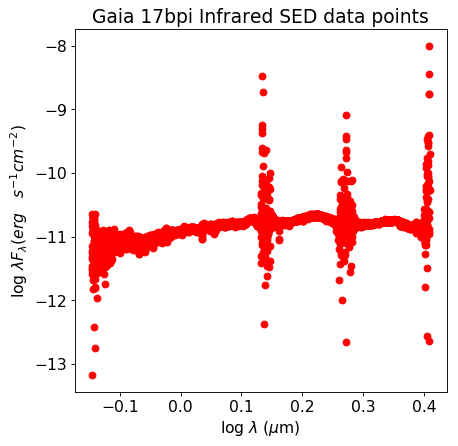

In [222]:
newtxt = getDataArray(PATH + 'Gaia17bpi.merged.txt')

wavesDATA_INF = newtxt[:,0] 
fluxesDATA_INF = newtxt[:,1]

fig=plt.figure(figsize=(6, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})

plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')

plt.title('Gaia 17bpi Infrared SED data points')

plt.plot(np.log10(wavesDATA_INF*1e-4), np.log10(fluxesDATA_INF * wavesDATA_INF), 'ro')
plt.show()

In [223]:
DIST = DIST = 1.27e3*3.08567758128e18
waves[3][2]
len(waves)

4

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


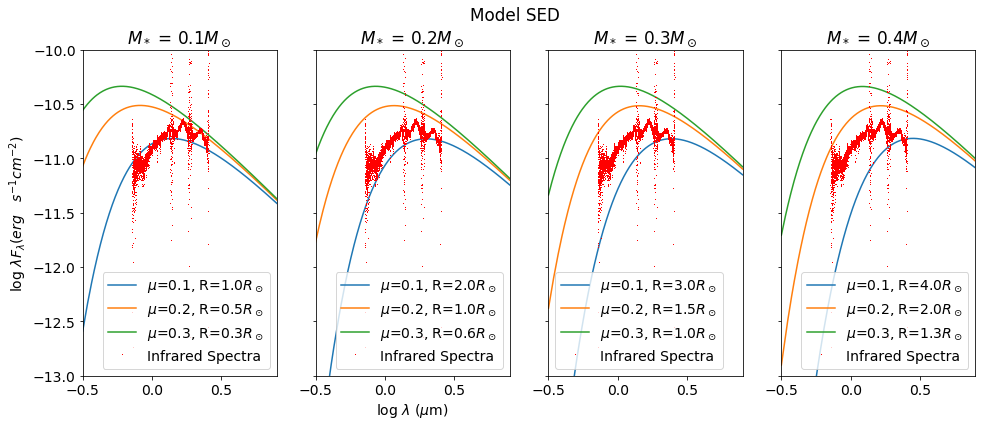

In [224]:
fig, axs = plt.subplots(1, len(M_STAR_TAB), figsize=(16, 6), sharey=True)
plt.rcParams.update({'font.size': 14})

axs[1].set_xlabel(r'log $\lambda$ ($\mu$m)')
axs[0].set_ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.suptitle('Model SED')

for i in range(len(waves)):
    for j in range(len(waves[0])):
        r_star = getRStar(MU_TAB[j], M_STAR_TAB[i])
        w = np.log10(waves[i][j]*1e-4)
        l = np.log10(np.cos(np.radians(INC))*lum[i][j]*waves[i][j]*1e-8/(2*np.pi*(DIST**2)))
        axs[i].plot(w, l, label=r'$\mu$=' +str(MU_TAB[j]) + ', R='+str(r_star/R_SUN)[:3]+r'$R_\odot$')

    axs[i].plot(np.log10(wavesDATA_INF*1e-4), np.log10(fluxesDATA_INF * wavesDATA_INF), 'r,', label='Infrared Spectra')
    axs[i].set_title(r'$M_*$ = ' + str(M_STAR_TAB[i]/M_SUN)+r'$M_\odot$')
    axs[i].legend()
    axs[i].set_ylim(-13, -10)
    axs[i].set_xlim(-0.5, 0.9)


plt.show()

In [225]:
R_OUTER = 800*R_SUN
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

MU_TAB = np.array([0.05, 0.075, 0.1, 0.2])
M_STAR_TAB = M_SUN*np.array([0.3, 0.4, 0.5, 0.6])
# M_DOT_TAB = (1e-6 * M_SUN / 3.154e7)*np.array([1.0, 2.0, 3.0])
M_DOT = 1.0* 1e-5 * M_SUN / 3.154e7
INC = 60.

def getRStar(mu, m_star):
    return (1/mu)*(m_star/M_SUN)*R_SUN

In [226]:
waves = []
lum = []
for i in range(len(M_STAR_TAB)):
    waves_n = []
    lum_n = []
    for j in range(len(MU_TAB)):
        try:
            print('Generating for M_STAR = ' + str(M_STAR_TAB[i]/M_SUN) + ' and MU = ' + str(MU_TAB[j]))
            r_star = getRStar(MU_TAB[j], M_STAR_TAB[i])
            gaia17bpi_BB = FUOri(r_star, r_star, R_OUTER, M_STAR_TAB[i], M_DOT, np.radians(INC))
            gaia17bpi_BB.setAnnuliValues(10000, 2000, 100, 2*r_star)
            gaia17bpi_BB.createAnnuliBlackbody(np.linspace(1000, 700000, 10000))
            waves_BB, lum_BB = gaia17bpi_BB.generateModelSpectrum(2000,600000, 1, 'linear')
        except:
            print('failed.')
            waves_BB, lum_BB = 1,1
        waves_n.append(waves_BB)
        lum_n.append(lum_BB)
    waves.append(waves_n)
    lum.append(lum_n)

Generating for M_STAR = 0.3 and MU = 0.05
Generating for M_STAR = 0.3 and MU = 0.075
Generating for M_STAR = 0.3 and MU = 0.1
Generating for M_STAR = 0.3 and MU = 0.2
Generating for M_STAR = 0.4 and MU = 0.05
Generating for M_STAR = 0.4 and MU = 0.075
Generating for M_STAR = 0.4 and MU = 0.1
Generating for M_STAR = 0.4 and MU = 0.2
Generating for M_STAR = 0.5 and MU = 0.05
failed.
Generating for M_STAR = 0.5 and MU = 0.075
Generating for M_STAR = 0.5 and MU = 0.1
Generating for M_STAR = 0.5 and MU = 0.2
Generating for M_STAR = 0.6 and MU = 0.05
failed.
Generating for M_STAR = 0.6 and MU = 0.075
Generating for M_STAR = 0.6 and MU = 0.1
Generating for M_STAR = 0.6 and MU = 0.2


C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


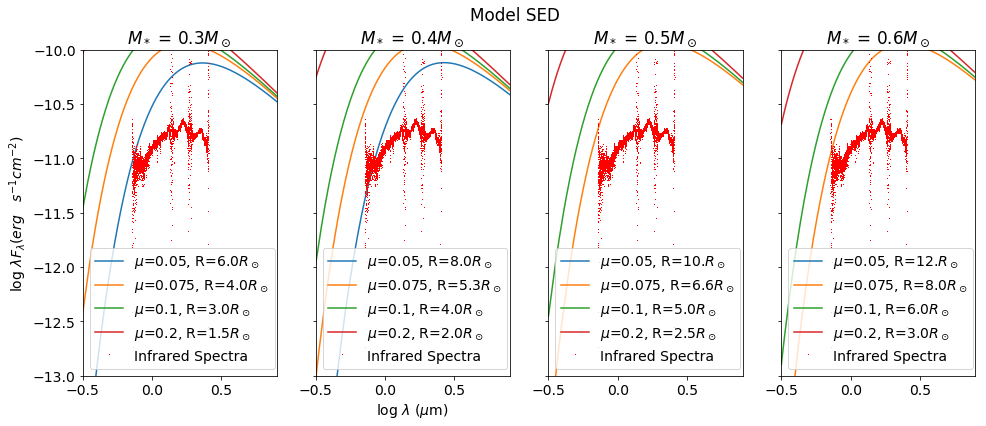

In [227]:
fig, axs = plt.subplots(1, len(M_STAR_TAB), figsize=(16, 6), sharey=True)
plt.rcParams.update({'font.size': 14})

axs[1].set_xlabel(r'log $\lambda$ ($\mu$m)')
axs[0].set_ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.suptitle('Model SED')

for i in range(len(waves)):
    for j in range(len(waves[0])):
        r_star = getRStar(MU_TAB[j], M_STAR_TAB[i])
        w = np.log10(waves[i][j]*1e-4)
        l = np.log10(np.cos(np.radians(INC))*lum[i][j]*waves[i][j]*1e-8/(2*np.pi*(DIST**2)))
        axs[i].plot(w, l, label=r'$\mu$=' +str(MU_TAB[j]) + ', R='+str(r_star/R_SUN)[:3]+r'$R_\odot$')

    axs[i].plot(np.log10(wavesDATA_INF*1e-4), np.log10(fluxesDATA_INF * wavesDATA_INF), 'r,', label='Infrared Spectra')
    axs[i].set_title(r'$M_*$ = ' + str(M_STAR_TAB[i]/M_SUN)+r'$M_\odot$')
    axs[i].legend()
    axs[i].set_ylim(-13, -10)
    axs[i].set_xlim(-0.5, 0.9)


plt.show()

### Just one set of parameters

In [210]:
R_OUTER = 800*R_SUN
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

MU = 0.1
M_STAR= M_SUN*0.5
M_DOT = 1.0* 1e-5 * M_SUN / 3.154e7
INC = 60.

r_star = getRStar(MU, M_STAR)
r_star/R_SUN

5.0

In [211]:
gaia17bpi_BB = FUOri(r_star, r_star, R_OUTER, M_STAR, M_DOT, np.radians(INC))

In [212]:
gaia17bpi_BB.setAnnuliValues(10000, 2000, 100, 2*r_star)

In [213]:
gaia17bpi_BB.createAnnuliBlackbody(np.linspace(1000, 700000, 10000))

In [204]:
waves_BB, lum_BB= gaia17bpi_BB.generateModelSpectrum(2000,600000, 1, 'linear')

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


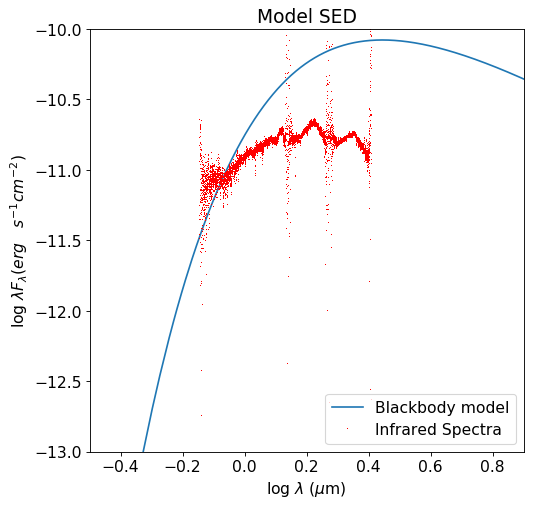

In [205]:
fig=plt.figure(figsize=(7, 7), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.title('Model SED')

w = np.log10(waves_BB*1e-4)
l = np.log10(np.cos(np.radians(INC))*lum_BB*waves_BB*1e-8/(2*np.pi*(DIST**2)))
plt.plot(w, l, label='Blackbody model')

plt.plot(np.log10(wavesDATA_INF*1e-4), np.log10(fluxesDATA_INF * wavesDATA_INF), 'r,', label='Infrared Spectra')
plt.legend()
plt.ylim(-13, -10)
plt.xlim(-0.5, 0.9)


plt.show()